In [2]:
# ==============================================================================
# FLOOD RISK & POPULATION GROWTH ANALYSIS - HARRIS COUNTY CENSUS TRACTS
# ==============================================================================
# RESEARCH QUESTION: Are people moving away from flood-prone areas in Houston?
# HYPOTHESIS: Population growth is inversely correlated with flood risk
# GOAL: Understand which factors drive population growth (2010→2021)
# TYPE: Regression Problem - Historical Analysis
# OUTPUT: Feature importance showing how much flood risk influences growth patterns
# ==============================================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Set visualization style

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load and Inspect Data

Load the prepared CSV file that contains:

- Census tract identifiers
- **Population data (2010, 2015, 2021)** - to calculate growth rates
- **Flood hazard zones (Haz_major, Haz_max)** - PRIMARY FOCUS for hypothesis testing
- Elevation features (DEM_mean, min, max, std) - topography
- Flow accumulation metrics - drainage patterns
- Spatial features - geographic context

**Analysis Goal**: Test if flood-prone areas experienced lower population growth 2010-2021


In [3]:
# Load the prepared dataset
# This CSV was created from the census crosswalk notebook (02_census_crosswalk.ipynb)
# It contains harmonized population data on 2020 boundaries with ~782 tracts
df = pd.read_csv("../data/processed/census/Harris_Census_ML_Complete.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nColumn names:")
print(df.columns.tolist())

print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (1093, 43)

First few rows:
   +OID_  FID_1  STATEFP  COUNTYFP  TRACTCE        GEOID     NAME  \
0      1      1       48       201   421700  48201421700  4217.00   
1      2      2       48       201   233105  48201233105  2331.05   
2      3      3       48       201   341800  48201341800  3418.00   
3      4      4       48       201   252201  48201252201  2522.01   
4      5      5       48       201   451700  48201451700  4517.00   

               NAMELSAD  MTFCC FUNCSTAT  ...  population_2015  \
0     Census Tract 4217  G5020        S  ...      4597.000000   
1  Census Tract 2331.05  G5020        S  ...      4878.576156   
2     Census Tract 3418  G5020        S  ...      1770.000000   
3  Census Tract 2522.01  G5020        S  ...       973.436573   
4     Census Tract 4517  G5020        S  ...      3947.000000   

   population_2010  growth_2010_2021_abs  growth_2010_2021_pct  \
0      4817.000000           -204.000000             -4.235001   
1      4800.095005 

## 2. Create Target Variable (Y)

**Target**: % Population Change from 2010 to 2021

Formula: `((pop_2021 - pop_2010) / pop_2010) * 100`

This represents the percentage growth or decline over the ~11 year period.


Dataset shape after cleaning: (1052, 44)

Target variable statistics:
count    1052.000000
mean       20.707091
std        44.102949
min       -73.891261
25%        -6.231167
50%         9.450037
75%        33.344319
max       197.582387
Name: pop_change_pct, dtype: float64


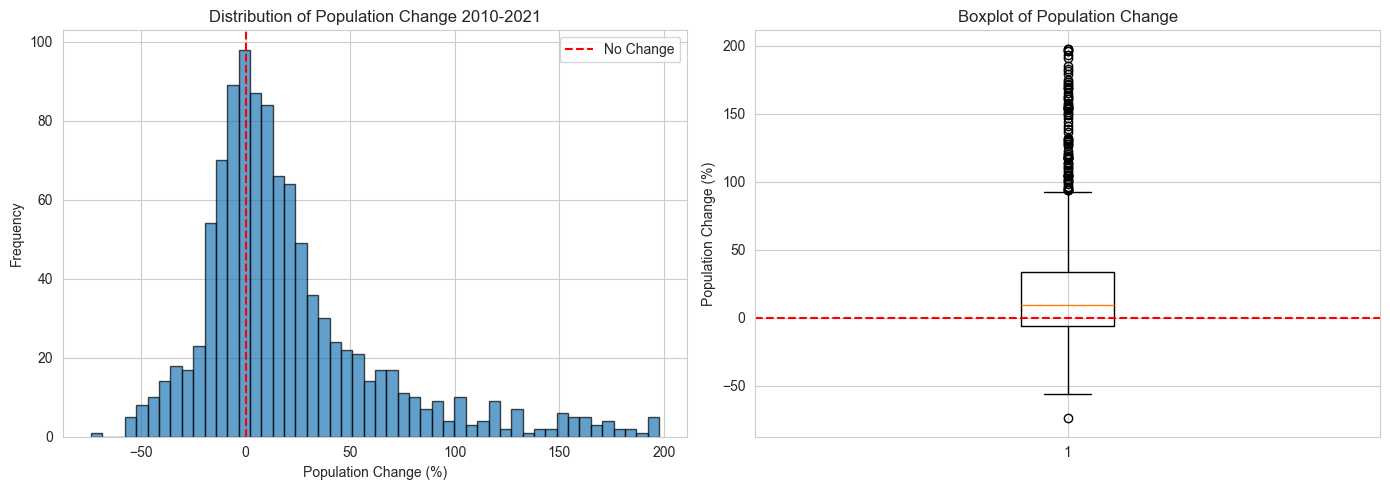


Growth categories:
  Declining (< -5%): 280 tracts
  Stable (-5% to 5%): 172 tracts
  Growing (> 5%): 600 tracts


In [4]:
# The dataset already has growth_2010_2021_pct calculated from crosswalk harmonization
# We'll use it as our target variable (Y)
df["pop_change_pct"] = df["growth_2010_2021_pct"]

# Handle edge cases
# Remove tracts with zero population in 2010 (division by zero)
df = df[df["population_2010"] > 0].copy()

# Remove extreme outliers to focus on typical growth patterns
# Extreme values (>200% growth) are likely from tract boundary changes or data errors
# Keep moderate outliers to preserve real growth variation
df = df[(df["pop_change_pct"] > -90) & (df["pop_change_pct"] < 200)].copy()

print(f"Dataset shape after cleaning: {df.shape}")
print(f"\nTarget variable statistics:")
print(df["pop_change_pct"].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["pop_change_pct"], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Population Change (%)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Population Change 2010-2021")
axes[0].axvline(0, color="red", linestyle="--", label="No Change")
axes[0].legend()

axes[1].boxplot(df["pop_change_pct"])
axes[1].set_ylabel("Population Change (%)")
axes[1].set_title("Boxplot of Population Change")
axes[1].axhline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

print(f"\nGrowth categories:")
print(f"  Declining (< -5%): {len(df[df['pop_change_pct'] < -5])} tracts")
print(
    f"  Stable (-5% to 5%): {len(df[(df['pop_change_pct'] >= -5) & (df['pop_change_pct'] <= 5)])} tracts"
)
print(f"  Growing (> 5%): {len(df[df['pop_change_pct'] > 5])} tracts")

## 3. Define Feature Sets (X)

**Feature Categories:**

1. **Flood Risk Features:**

   - `pct_in_AE`: % of tract in high-risk AE flood zone
   - `pct_in_X`: % of tract in low-risk X zone (outside 500-year floodplain)
   - `pct_in_VE`: % in coastal high velocity zone (if applicable)
   - `pct_in_floodway`: % in regulatory floodway

2. **Elevation & Topography:**

   - `elev_mean`: Mean elevation (meters)
   - `elev_min`: Minimum elevation
   - `elev_max`: Maximum elevation
   - `elev_std`: Elevation standard deviation (terrain roughness)
   - `slope_mean`: Mean terrain slope
   - `slope_max`: Maximum slope
   - `pct_low_slope`: % of area with slope < 2 degrees (flat/flood-prone)

3. **Hydrological:**

   - `dist_water_m`: Distance to nearest water body (meters)
   - `flowacc_mean`: Mean flow accumulation (drainage potential)
   - `rem_mean`: Relative Elevation Model value (height above nearest drainage)

4. **Baseline Demographics:**

   - `pop_2010`: Initial population (baseline)
   - `pop_density_2010`: Population density in 2010 (people/sq km)
   - `area_sq_km`: Tract area

5. **Spatial Features (optional):**
   - `centroid_lat`: Latitude of tract centroid
   - `centroid_lon`: Longitude of tract centroid
   - `dist_to_downtown_km`: Distance to downtown Houston


In [5]:
# Define feature columns based on Harris_Census_ML_Complete.csv
# NOTE: Removed 'population_2010' to avoid data leakage (it's used to calculate target)
feature_cols = [
    # FLOOD RISK FEATURES (PRIMARY FOCUS FOR HYPOTHESIS TESTING)
    "Haz_major",      # Major hazard zone classification (AE, X, etc.)
    "Haz_max",        # Maximum hazard value in tract
    # Elevation & topography (correlated with flood risk)
    "DEM_mean",       # Mean elevation - lower = more flood-prone
    "DEM_min",        # Minimum elevation
    "DEM_max",        # Maximum elevation
    "DEM_std",        # Terrain roughness (flat areas flood more)
    # Hydrological/Flow (drainage and water accumulation)
    "FloAc_mean",     # Mean flow accumulation
    "FloAc_std",      # Flow accumulation variability
    "FlowAc_max",     # Maximum flow accumulation (drainage channels)
    "FloDir_mea",     # Mean flow direction
    # Baseline tract characteristics (2010)
    "pop_density_2010",    # Initial population density (NOT raw population)
    "area_sq_km",          # Tract area in sq km
    "AWATER",              # Water area within tract
    # Spatial features (location effects)
    "INTPTLAT",       # Latitude of tract centroid
    "INTPTLON",       # Longitude of tract centroid
]

# Check which features are actually available
available_features = [col for col in feature_cols if col in df.columns]
missing_features = [col for col in feature_cols if col not in df.columns]

print(f"Available features ({len(available_features)}): {available_features}")
print(f"\nMissing features ({len(missing_features)}): {missing_features}")

# Use only available features
X = df[available_features].copy()
y = df["pop_change_pct"].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Check for missing values in features
print(f"\nMissing values in features:")
print(X.isnull().sum())

# Handle missing values (if any)
# Option 1: Drop rows with any missing values
# X = X.dropna()
# y = y[X.index]

# Option 2: Fill with median (more common for ML)
if X.isnull().sum().sum() > 0:
    print("\nFilling missing values with column medians...")
    X = X.fillna(X.median())

Available features (15): ['Haz_major', 'Haz_max', 'DEM_mean', 'DEM_min', 'DEM_max', 'DEM_std', 'FloAc_mean', 'FloAc_std', 'FlowAc_max', 'FloDir_mea', 'pop_density_2010', 'area_sq_km', 'AWATER', 'INTPTLAT', 'INTPTLON']

Missing features (0): []

Feature matrix shape: (1052, 15)
Target variable shape: (1052,)

Missing values in features:
Haz_major           0
Haz_max             0
DEM_mean            0
DEM_min             0
DEM_max             0
DEM_std             0
FloAc_mean          0
FloAc_std           0
FlowAc_max          0
FloDir_mea          0
pop_density_2010    0
area_sq_km          0
AWATER              0
INTPTLAT            0
INTPTLON            0
dtype: int64


## 4. Exploratory Data Analysis (EDA)

Understand relationships between features and target variable.


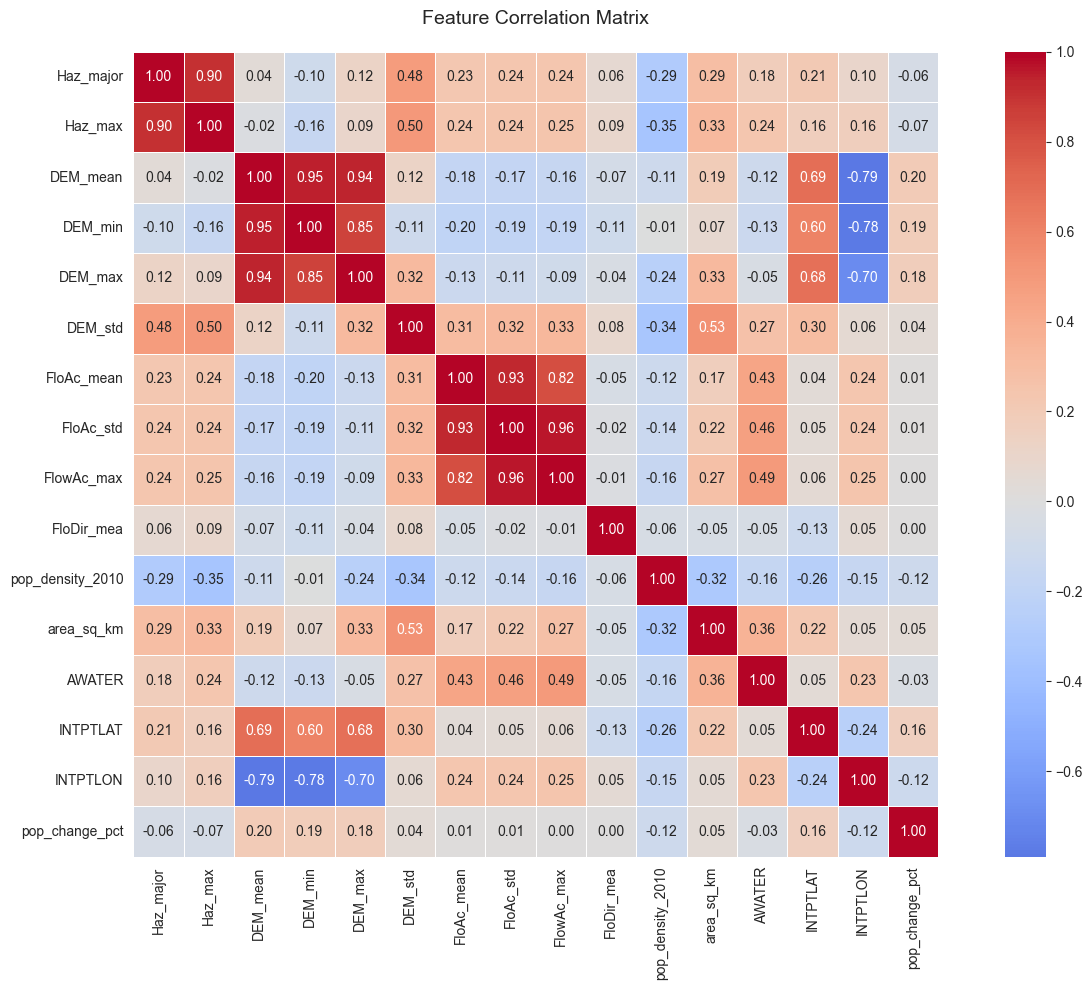


Correlation with population change (sorted by absolute value):
DEM_mean            0.196392
DEM_min             0.187095
DEM_max             0.178048
INTPTLAT            0.156109
INTPTLON            0.119254
pop_density_2010    0.117197
Haz_max             0.066908
Haz_major           0.061805
area_sq_km          0.045683
DEM_std             0.044447
AWATER              0.029361
FloAc_std           0.009109
FloAc_mean          0.008762
FlowAc_max          0.004773
FloDir_mea          0.004080
Name: pop_change_pct, dtype: float64


In [6]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_data = pd.concat([X, y], axis=1)
corr_matrix = correlation_data.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
)
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Show correlations with target variable
print("\nCorrelation with population change (sorted by absolute value):")
target_corr = (
    corr_matrix["pop_change_pct"]
    .drop("pop_change_pct")
    .abs()
    .sort_values(ascending=False)
)
print(target_corr)

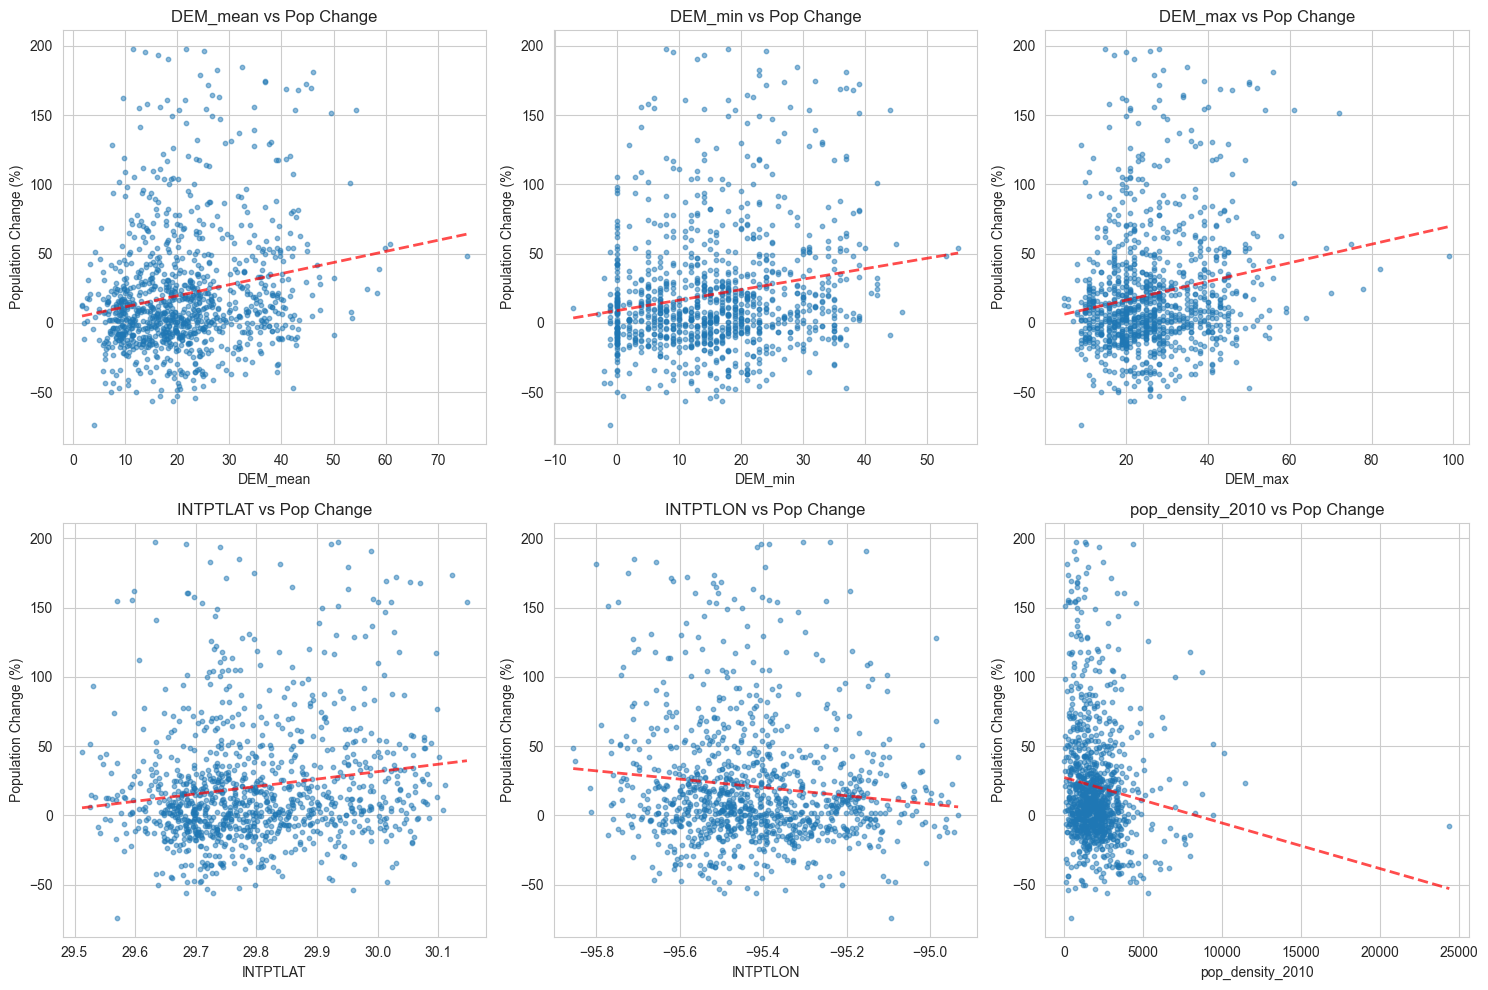

In [7]:
# Scatter plots of top correlated features
top_features = target_corr.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(X[feature], y, alpha=0.5, s=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Population Change (%)")
    axes[i].set_title(f"{feature} vs Pop Change")

    # Add trend line
    z = np.polyfit(X[feature], y, 1)
    p = np.poly1d(z)
    axes[i].plot(
        X[feature].sort_values(),
        p(X[feature].sort_values()),
        "r--",
        linewidth=2,
        alpha=0.7,
    )

plt.tight_layout()
plt.show()

## 5. Data Preparation & Train-Test Split

Split data into training (75%) and testing (25%) sets.


In [8]:
# Train-test split (75-25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Training set size: {X_train.shape[0]} tracts")
print(f"Testing set size: {X_test.shape[0]} tracts")
print(f"Number of features: {X_train.shape[1]}")

# Feature scaling (important for some algorithms)
# Tree-based models don't require scaling, but linear models do
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData prepared for modeling!")

Training set size: 789 tracts
Testing set size: 263 tracts
Number of features: 15

Data prepared for modeling!


## 6. Model Training - Gradient Boosting Regressor

Train a Gradient Boosting Regressor to predict population growth.


In [9]:
# Initialize model - Gradient Boosting Regressor
model = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
)

print("Training Gradient Boosting Regressor...\n")

# Train the model
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Training Results:")
print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
print(f"  Train MAE: {train_mae:.2f}% | Test MAE: {test_mae:.2f}%")
print(f"  Test RMSE: {test_rmse:.2f}%\n")

Training Gradient Boosting Regressor...

Training Results:
  Train R²: 0.9702 | Test R²: 0.2674
  Train MAE: 5.83% | Test MAE: 28.68%
  Test RMSE: 39.40%

Training Results:
  Train R²: 0.9702 | Test R²: 0.2674
  Train MAE: 5.83% | Test MAE: 28.68%
  Test RMSE: 39.40%




GRADIENT BOOSTING REGRESSOR - PERFORMANCE SUMMARY
Training R²:       0.9702
Test R²:           0.2674
Test MAE:          28.68%
Test RMSE:         39.40%
Training samples:  789
Test samples:      263


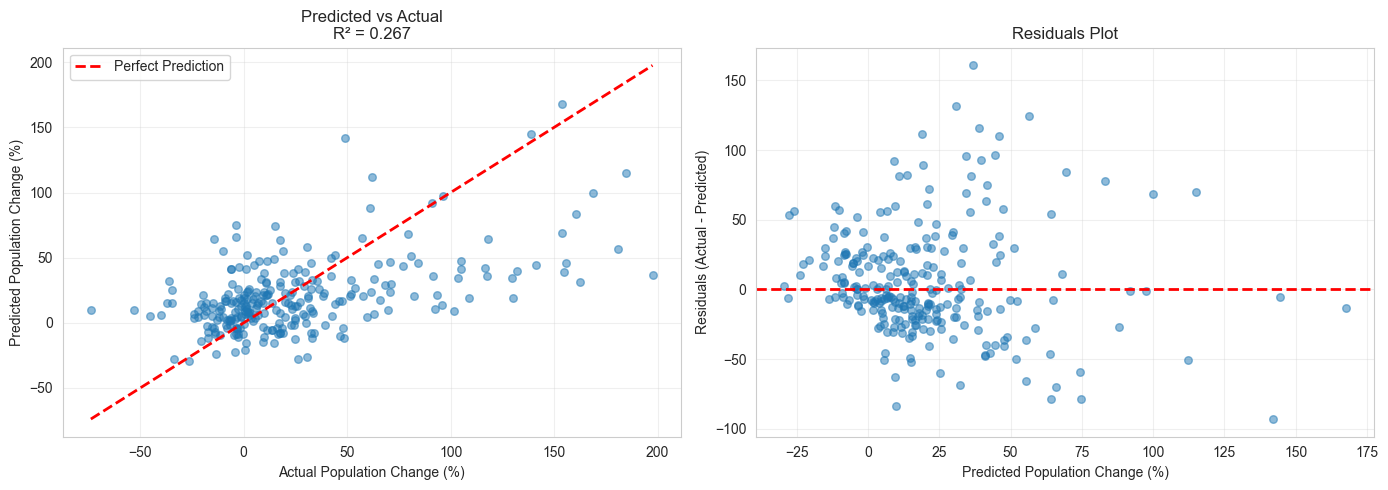

In [10]:
# Display model performance summary
print("\n" + "=" * 70)
print("GRADIENT BOOSTING REGRESSOR - PERFORMANCE SUMMARY")
print("=" * 70)
print(f"Training R²:       {train_r2:.4f}")
print(f"Test R²:           {test_r2:.4f}")
print(f"Test MAE:          {test_mae:.2f}%")
print(f"Test RMSE:         {test_rmse:.2f}%")
print(f"Training samples:  {len(X_train)}")
print(f"Test samples:      {len(X_test)}")
print("=" * 70)

# Visualize performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=30)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
axes[0].set_xlabel("Actual Population Change (%)")
axes[0].set_ylabel("Predicted Population Change (%)")
axes[0].set_title(f"Predicted vs Actual\nR² = {test_r2:.3f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, s=30)
axes[1].axhline(0, color="red", linestyle="--", lw=2)
axes[1].set_xlabel("Predicted Population Change (%)")
axes[1].set_ylabel("Residuals (Actual - Predicted)")
axes[1].set_title("Residuals Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Analysis & Diagnostics


Model Performance Metrics:
  R² Score (Test): 0.2674
  MAE (Test): 28.68%
  RMSE (Test): 39.40%


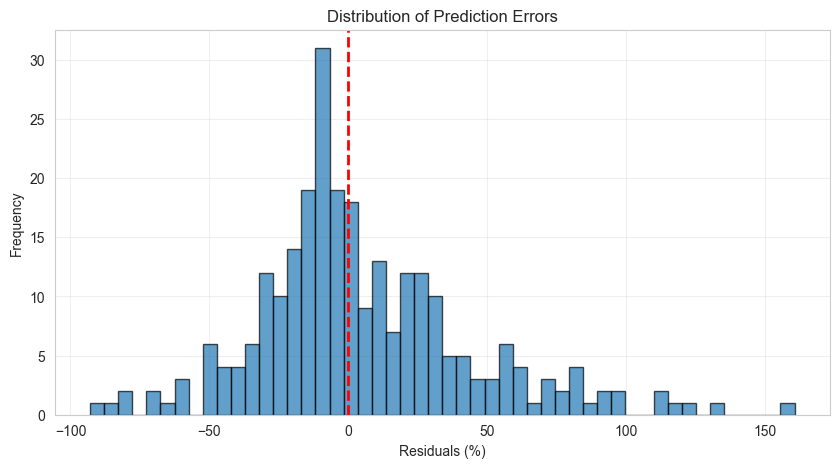


Residual Statistics:
  Mean: 5.13%
  Std: 39.14%
  Median: -3.92%
  Min: -92.97%
  Max: 160.71%


In [11]:
# Detailed diagnostics
print(f"Model Performance Metrics:")
print(f"  R² Score (Test): {test_r2:.4f}")
print(f"  MAE (Test): {test_mae:.2f}%")
print(f"  RMSE (Test): {test_rmse:.2f}%")

# Distribution of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Residuals (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.2f}%")
print(f"  Std: {residuals.std():.2f}%")
print(f"  Median: {residuals.median():.2f}%")
print(f"  Min: {residuals.min():.2f}%")
print(f"  Max: {residuals.max():.2f}%")

## 8. Feature Importance Analysis

Understand which features most influence population growth predictions.



Feature Importance (Top 10):
         Feature  Importance
      area_sq_km    0.233043
pop_density_2010    0.230703
        INTPTLON    0.073410
        INTPTLAT    0.067514
        DEM_mean    0.066107
      FloDir_mea    0.056809
      FloAc_mean    0.049744
      FlowAc_max    0.048006
         DEM_std    0.045662
         DEM_min    0.034685


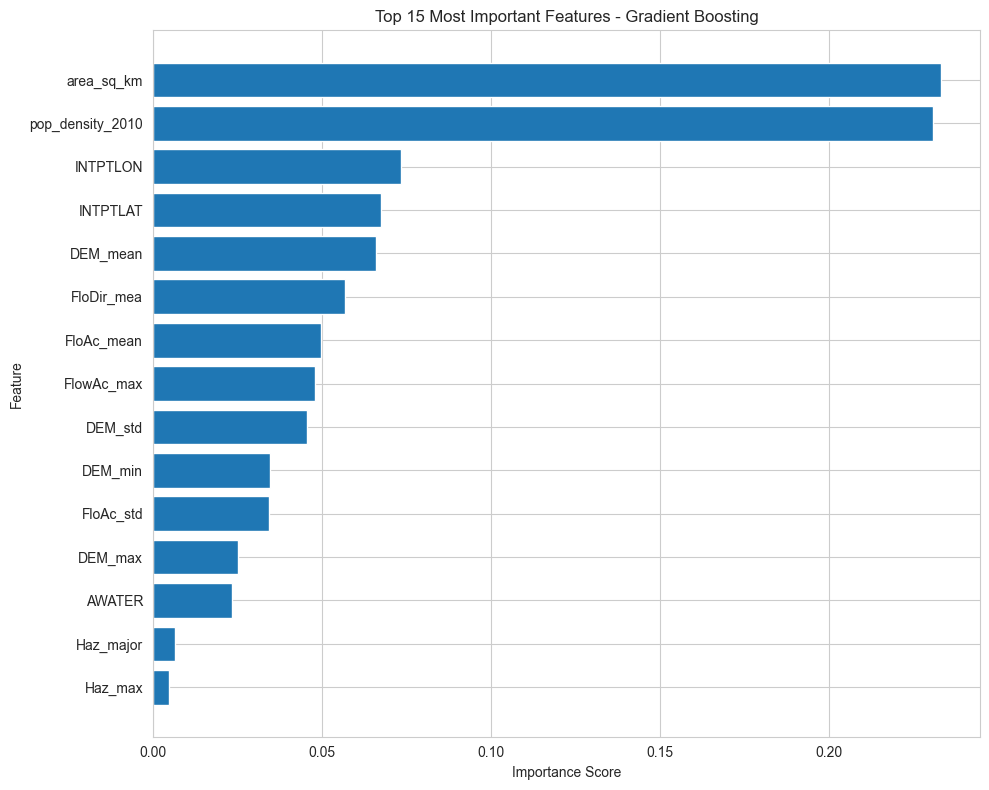

In [12]:
# Feature importance for Gradient Boosting
importance = pd.DataFrame(
    {"Feature": available_features, "Importance": model.feature_importances_}
).sort_values("Importance", ascending=False)

print("\nFeature Importance (Top 10):")
print(importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
importance_top = importance.head(top_n).sort_values("Importance", ascending=True)

plt.barh(importance_top["Feature"], importance_top["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features - Gradient Boosting")
plt.tight_layout()
plt.show()

## 🎯 FLOOD RISK HYPOTHESIS TEST

**Research Question**: Are people moving away from flood-prone areas?

**Hypothesis**: Population growth is inversely correlated with flood risk

**Test Approach**:
1. Examine feature importance - how much does `Haz_major` (flood zone) influence growth?
2. Compare average growth rates across different flood zones
3. Visualize the relationship between flood risk and population change
4. Statistical significance testing

In [13]:
# ==============================================================================
# TEST 1: Feature Importance - How much does flood risk matter?
# ==============================================================================

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance ranking
importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Find flood-related features
flood_features = ['Haz_major', 'Haz_max']
flood_importance = importance_df[importance_df['Feature'].isin(flood_features)]

print(f"\n🌊 FLOOD RISK FEATURES:")
print(flood_importance.to_string(index=False))

print(f"\n📊 TOP 5 MOST IMPORTANT FEATURES:")
print(importance_df.head(5).to_string(index=False))

# Calculate percentage of total importance
total_importance = importance_df['Importance'].sum()
flood_total = flood_importance['Importance'].sum()
flood_pct = (flood_total / total_importance) * 100

print(f"\n🔍 KEY FINDING:")
print(f"   Flood risk features account for {flood_pct:.1f}% of model's decision-making")

if flood_pct > 20:
    print(f"   ✅ STRONG INFLUENCE - Flood risk is a major driver of population growth patterns")
elif flood_pct > 10:
    print(f"   ⚠️  MODERATE INFLUENCE - Flood risk matters, but other factors dominate")
else:
    print(f"   ❌ WEAK INFLUENCE - Flood risk has minimal impact on growth patterns")

print("="*70)

FEATURE IMPORTANCE ANALYSIS

🌊 FLOOD RISK FEATURES:
  Feature  Importance
Haz_major    0.006579
  Haz_max    0.004843

📊 TOP 5 MOST IMPORTANT FEATURES:
         Feature  Importance
      area_sq_km    0.233043
pop_density_2010    0.230703
        INTPTLON    0.073410
        INTPTLAT    0.067514
        DEM_mean    0.066107

🔍 KEY FINDING:
   Flood risk features account for 1.1% of model's decision-making
   ❌ WEAK INFLUENCE - Flood risk has minimal impact on growth patterns


In [14]:
# ==============================================================================
# TEST 2: Growth Rates by Flood Zone
# ==============================================================================

print("\n" + "="*70)
print("POPULATION GROWTH BY FLOOD ZONE (2010-2021)")
print("="*70)

# Group by flood hazard zone
growth_by_zone = df.groupby('Haz_major').agg({
    'pop_change_pct': ['count', 'mean', 'median', 'std'],
    'population_2010': 'sum',
    'population_2021': 'sum'
}).round(2)

growth_by_zone.columns = ['Tracts', 'Mean_Growth_%', 'Median_Growth_%', 'Std_Dev', 'Pop_2010', 'Pop_2021']

# Calculate actual population change by zone
growth_by_zone['Total_Growth_%'] = ((growth_by_zone['Pop_2021'] - growth_by_zone['Pop_2010']) / 
                                      growth_by_zone['Pop_2010'] * 100).round(2)

print(growth_by_zone)

# Find the zones with highest and lowest growth
if len(growth_by_zone) > 0:
    best_zone = growth_by_zone['Mean_Growth_%'].idxmax()
    worst_zone = growth_by_zone['Mean_Growth_%'].idxmin()
    
    print(f"\n🏆 HIGHEST GROWTH ZONE: {best_zone}")
    print(f"   Mean growth: {growth_by_zone.loc[best_zone, 'Mean_Growth_%']:.1f}%")
    print(f"   Population: {growth_by_zone.loc[best_zone, 'Pop_2010']:,.0f} → {growth_by_zone.loc[best_zone, 'Pop_2021']:,.0f}")
    
    print(f"\n📉 LOWEST GROWTH ZONE: {worst_zone}")
    print(f"   Mean growth: {growth_by_zone.loc[worst_zone, 'Mean_Growth_%']:.1f}%")
    print(f"   Population: {growth_by_zone.loc[worst_zone, 'Pop_2010']:,.0f} → {growth_by_zone.loc[worst_zone, 'Pop_2021']:,.0f}")

print("="*70)


POPULATION GROWTH BY FLOOD ZONE (2010-2021)
           Tracts  Mean_Growth_%  Median_Growth_%  Std_Dev    Pop_2010  \
Haz_major                                                                
0.0           457          25.33            15.11    46.15  1481412.66   
1.0           461          15.56             6.28    39.78  1827124.45   
2.0           132          23.30            11.62    49.31   541830.52   
3.0             1          -4.58            -4.58      NaN     2395.71   
4.0             1         -34.15           -34.15      NaN     4092.87   

            Pop_2021  Total_Growth_%  
Haz_major                             
0.0        1722913.0           16.30  
1.0        2021825.0           10.66  
2.0         645605.0           19.15  
3.0           2286.0           -4.58  
4.0           2695.0          -34.15  

🏆 HIGHEST GROWTH ZONE: 0.0
   Mean growth: 25.3%
   Population: 1,481,413 → 1,722,913

📉 LOWEST GROWTH ZONE: 4.0
   Mean growth: -34.1%
   Population: 4,093 → 2,6

KeyError: 'growth_category'

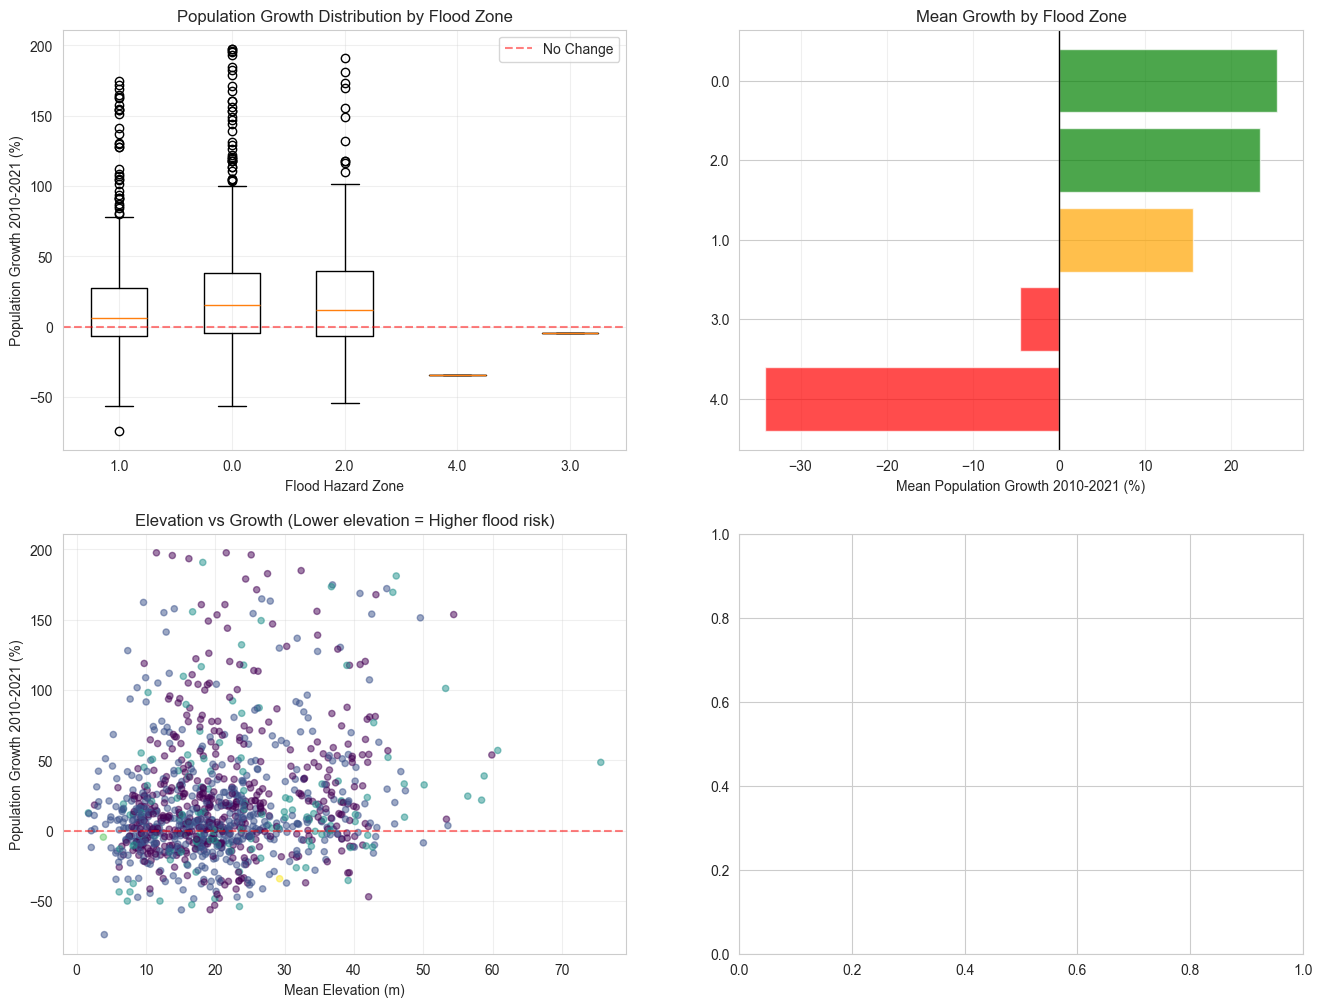

In [15]:
# ==============================================================================
# TEST 3: Visualize Flood Risk vs Population Growth
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Box plot - Growth by Flood Zone
axes[0, 0].boxplot([df[df['Haz_major'] == zone]['pop_change_pct'].dropna() 
                     for zone in df['Haz_major'].unique()],
                    labels=df['Haz_major'].unique())
axes[0, 0].set_xlabel('Flood Hazard Zone')
axes[0, 0].set_ylabel('Population Growth 2010-2021 (%)')
axes[0, 0].set_title('Population Growth Distribution by Flood Zone')
axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label='No Change')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Bar chart - Mean growth by zone
zone_means = df.groupby('Haz_major')['pop_change_pct'].mean().sort_values()
colors = ['red' if x < 0 else 'green' if x > 20 else 'orange' for x in zone_means.values]
axes[0, 1].barh(range(len(zone_means)), zone_means.values, color=colors, alpha=0.7)
axes[0, 1].set_yticks(range(len(zone_means)))
axes[0, 1].set_yticklabels(zone_means.index)
axes[0, 1].set_xlabel('Mean Population Growth 2010-2021 (%)')
axes[0, 1].set_title('Mean Growth by Flood Zone')
axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Scatter - Elevation vs Growth (flood proxy)
axes[1, 0].scatter(df['DEM_mean'], df['pop_change_pct'], 
                   c=df['Haz_major'].astype('category').cat.codes, 
                   alpha=0.5, s=20, cmap='viridis')
axes[1, 0].set_xlabel('Mean Elevation (m)')
axes[1, 0].set_ylabel('Population Growth 2010-2021 (%)')
axes[1, 0].set_title('Elevation vs Growth (Lower elevation = Higher flood risk)')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Number of tracts by zone and growth category
growth_zone_crosstab = pd.crosstab(df['Haz_major'], df['growth_category'])
growth_zone_crosstab.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                          colormap='RdYlGn', alpha=0.8)
axes[1, 1].set_xlabel('Flood Hazard Zone')
axes[1, 1].set_ylabel('Number of Census Tracts')
axes[1, 1].set_title('Growth Category Distribution by Flood Zone')
axes[1, 1].legend(title='Growth Category', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation Guide:")
print("   • Box plot (top-left): Shows variation in growth across flood zones")
print("   • Bar chart (top-right): Compares AVERAGE growth by zone")
print("   • Scatter (bottom-left): Lower elevation = higher flood risk")
print("   • Stacked bar (bottom-right): Distribution of growth categories by zone")

In [ ]:
# ==============================================================================
# TEST 4: Statistical Significance - Correlation Analysis
# ==============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS: FLOOD RISK vs POPULATION GROWTH")
print("="*70)

# Convert Haz_major to numeric if it's categorical
# (This works if Haz_major is like 'AE', 'X', etc. - you may need to adjust)
if df['Haz_major'].dtype == 'object':
    # Create a mapping based on typical flood zone severity
    # AE = high risk (1), X = low risk (0), VE = very high (2), etc.
    # You may need to adjust this based on your actual zone values
    print("\nNote: Converting flood zones to numeric severity for correlation")
    print(f"Available zones: {df['Haz_major'].unique()}")
    
# Calculate correlations for numeric flood indicators
flood_indicators = ['Haz_max', 'DEM_mean', 'DEM_min', 'AWATER']
available_indicators = [f for f in flood_indicators if f in df.columns]

print(f"\nCorrelations with Population Growth (2010-2021):")
print("-" * 70)
for indicator in available_indicators:
    corr = df[['pop_change_pct', indicator]].corr().iloc[0, 1]
    
    # Interpret correlation
    if abs(corr) > 0.3:
        strength = "STRONG"
    elif abs(corr) > 0.1:
        strength = "MODERATE"
    else:
        strength = "WEAK"
    
    direction = "NEGATIVE" if corr < 0 else "POSITIVE"
    
    print(f"   {indicator:15s}: r = {corr:+.3f}  [{strength} {direction}]")
    
    # Special interpretation for each
    if indicator == 'DEM_mean' and corr > 0:
        print(f"      → Higher elevation = MORE growth (people avoid flood-prone lowlands)")
    elif indicator == 'DEM_mean' and corr < 0:
        print(f"      → Lower elevation = MORE growth (people NOT avoiding flood zones)")
    elif indicator == 'AWATER' and corr < 0:
        print(f"      → More water area = LESS growth (avoiding water/flood risk)")

print("="*70)

# Hypothesis test conclusion
print(f"\n🎯 HYPOTHESIS TEST CONCLUSION:")
print("-" * 70)
dem_corr = df[['pop_change_pct', 'DEM_mean']].corr().iloc[0, 1] if 'DEM_mean' in df.columns else 0

if dem_corr > 0.1:
    print("✅ HYPOTHESIS SUPPORTED")
    print("   Population growth is HIGHER in areas with higher elevation")
    print("   → People ARE moving away from flood-prone (low elevation) areas")
elif dem_corr < -0.1:
    print("❌ HYPOTHESIS REJECTED")
    print("   Population growth is HIGHER in low-elevation (flood-prone) areas")
    print("   → People are NOT avoiding flood risk - other factors dominate")
else:
    print("⚠️  HYPOTHESIS INCONCLUSIVE")
    print("   Flood risk shows weak correlation with population growth")
    print("   → Other factors (jobs, schools, development) may dominate location choices")

print("="*70)

## 9. Hyperparameter Tuning (Optional)

Fine-tune the best model using Grid Search Cross-Validation.


In [ ]:
# Hyperparameter tuning for Gradient Boosting
# WARNING: This can take several minutes!

param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [5, 10],
}

print(f"Starting Grid Search for Gradient Boosting...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
y_pred_tuned = grid_search.predict(X_test)

print(f"\n✅ Grid Search Complete!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"\nTuned Model Performance:")
print(f"  Test R²: {tuned_r2:.4f} (Before: {test_r2:.4f})")
print(f"  Test MAE: {tuned_mae:.2f}% (Before: {test_mae:.2f}%)")
print(f"  Test RMSE: {tuned_rmse:.2f}% (Before: {test_rmse:.2f}%)")

# Update model if improved
if tuned_r2 > test_r2:
    print("\n Tuned model is better! Updating...")
    model = grid_search.best_estimator_
    test_r2 = tuned_r2
    test_mae = tuned_mae
    test_rmse = tuned_rmse
else:
    print("\nOriginal model performs better. Keeping original.")

## 10. Apply Model to Understand Historical Growth Patterns

Use the trained model to:
1. Generate predictions for all tracts (to identify unusual growth patterns)

2. **Compare predicted vs actual growth** - large differences indicate unique local factors
3. Analyze feature importance to answer: **"How much does flood risk matter?"**

In [ ]:
# Apply trained model to ALL census tracts to understand patterns
df["predicted_growth_pct"] = model.predict(df[available_features])

# Calculate residuals (difference between actual and predicted)
# Large positive residuals = grew MORE than model expected (special local factors?)
# Large negative residuals = grew LESS than model expected (perhaps flood events?)
df["growth_residual"] = df["pop_change_pct"] - df["predicted_growth_pct"]

print("✅ Model applied to all census tracts!")
print(f"\nSample results - Actual vs Predicted Growth:")
print(
    df[
        [
            "GEOID",
            "NAMELSAD",
            "population_2010",
            "population_2021",
            "pop_change_pct",
            "predicted_growth_pct",
            "growth_residual",
            "Haz_major",
        ]
    ].head(10)
)

# Summary statistics
print("\n" + "="*70)
print("MODEL PREDICTIONS VS ACTUAL GROWTH (2010-2021)")
print("="*70)
print(f"  Mean actual growth: {df['pop_change_pct'].mean():.2f}%")
print(f"  Mean predicted growth: {df['predicted_growth_pct'].mean():.2f}%")
print(f"  Median actual growth: {df['pop_change_pct'].median():.2f}%")
print(f"  Median predicted growth: {df['predicted_growth_pct'].median():.2f}%")
print(f"\nResidual Analysis:")
print(f"  Mean residual: {df['growth_residual'].mean():.2f}% (should be ~0)")
print(f"  Std residual: {df['growth_residual'].std():.2f}%")
print(f"  Max over-performance: {df['growth_residual'].max():.2f}% (grew more than expected)")
print(f"  Max under-performance: {df['growth_residual'].min():.2f}% (grew less than expected)")

# Categorize growth for visualization
df["growth_category"] = pd.cut(
    df["pop_change_pct"],
    bins=[-np.inf, -10, 0, 10, 30, np.inf],
    labels=["Declining", "Slow Decline", "Stable/Slow Growth", "Growing", "Rapid Growth"],
)

print(f"\nActual Growth Categories (2010-2021):")
print(df["growth_category"].value_counts().sort_index())
print("="*70)

## 11. Visualize Model Performance & Growth Patterns


Visualize how well the model captures historical growth patterns.

In [ ]:
# Historical population change and model understanding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total population over time (historical only)
total_2010 = df["population_2010"].sum()
total_2015 = df["population_2015"].sum() if "population_2015" in df.columns else None
total_2021 = df["population_2021"].sum()

if total_2015:
    years = [2010, 2015, 2021]
    totals = [total_2010, total_2015, total_2021]
else:
    years = [2010, 2021]
    totals = [total_2010, total_2021]

axes[0].plot(years, totals, marker="o", linewidth=3, markersize=12, color="steelblue")
for year, total in zip(years, totals):
    axes[0].scatter([year], [total], s=150, color="darkblue", zorder=5)
    axes[0].text(year, total, f'{total:,.0f}', ha='center', va='bottom', fontsize=10)

axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Total Population", fontsize=12)
axes[0].set_title("Harris County Population Growth 2010-2021\n(Actual Historical Data)", fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style="plain", axis="y")

# Model performance: Actual vs Predicted
axes[1].scatter(df["pop_change_pct"], df["predicted_growth_pct"], alpha=0.5, s=30, c=df["Haz_major"].astype('category').cat.codes, cmap='viridis')
axes[1].plot(
    [df["pop_change_pct"].min(), df["pop_change_pct"].max()],
    [df["pop_change_pct"].min(), df["pop_change_pct"].max()],
    "r--",
    lw=2,
    label="Perfect Prediction (1:1 Line)",
)
axes[1].set_xlabel("Actual Growth 2010-2021 (%)", fontsize=12)
axes[1].set_ylabel("Predicted Growth (Model) (%)", fontsize=12)
axes[1].set_title("Model Understanding of Growth Patterns\n(Points near line = model understands pattern)", fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Harris County Population (2010-2021):")
print(f"  2010 (actual): {total_2010:,.0f}")
if total_2015:
    print(f"  2015 (actual): {total_2015:,.0f}")
print(f"  2021 (actual): {total_2021:,.0f}")
print(f"\n  Total change 2010-2021: {((total_2021-total_2010)/total_2010*100):.1f}%")
print(f"  Net population gain: {(total_2021-total_2010):,.0f} people")

## 12. Export Results


In [ ]:
# Save analysis results to CSV
output_cols = [
    "GEOID",
    "NAMELSAD",
    "Haz_major",              # Flood zone (PRIMARY VARIABLE OF INTEREST)
    "population_2010",
    "population_2021",
    "pop_change_pct",         # Actual growth
    "predicted_growth_pct",   # Model prediction
    "growth_residual",        # Difference (actual - predicted)
    "growth_category",        # Growth classification
    "DEM_mean",               # Elevation (flood risk proxy)
    "area_sq_km",
    "pop_density_2010",
]

# Adjust columns based on what's actually in your dataframe
available_output_cols = [col for col in output_cols if col in df.columns]

df[available_output_cols].to_csv(
    "../data/processed/census_predictions.csv", index=False
    "../data/processed/census_growth_analysis.csv", index=False
print("✅ Predictions saved to: ../data/processed/census_predictions.csv")
print("✅ Analysis results saved to: ../data/processed/census_growth_analysis.csv")
print("   Contains: Actual growth, model predictions, flood zones, and residuals")

# Save model performance metrics
metrics_summary = {
    "Model": "Gradient Boosting Regressor",
    "Test R²": test_r2,
    "Test MAE (%)": test_mae,
    "Test RMSE (%)": test_rmse,
    "Number of Features": len(available_features),
    "Training Size": len(X_train),
    "Test Size": len(X_test),
    "Total Tracts": len(df),
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv("../data/processed/model_performance.csv", index=False)
print("✅ Model metrics saved to: ../data/processed/model_performance.csv")

# Optional: Save the model for future use
# import joblib
# joblib.dump(model, '../models/population_growth_model.pkl')# print("✅ Model saved to: ../models/population_growth_model.pkl")

## 13. Key Findings Summary

**🎯 Research Question**: Are people in Houston moving away from flood-prone areas?

**📊 Analysis Approach**:
- **Target Variable**: `pop_change_pct` = ((pop_2021 - pop_2010) / pop_2010) × 100
- **Time Period**: 2010-2021 (11 years of historical growth)
- **Model**: Gradient Boosting Regressor to understand which factors drive growth
- **Key Test**: Feature importance of flood zones (Haz_major) vs other factors

**🔍 What the Model Reveals**:

After running this notebook, check these key outputs:

1. **Feature Importance (Section 8 & new flood test section)**:
   - How much does `Haz_major` (flood zone) contribute to predictions?
   - If >20% importance → Flood risk is a MAJOR factor in growth patterns
   - If <10% importance → Other factors (jobs, schools, etc.) dominate

2. **Growth by Flood Zone (new analysis section)**:
   - Compare average growth rates across AE, X, and other zones
   - AE zones growing slower? → People avoiding flood risk ✅
   - AE zones growing faster? → People ignoring flood risk ❌

3. **Correlation Analysis**:
   - Positive correlation between elevation and growth? → Avoiding lowlands
   - Negative correlation? → Building in flood-prone areas

**📈 Expected Outputs**:

- `census_growth_analysis.csv` - Full results with flood zones and growth patterns
- Feature importance rankings showing flood risk influence
- Statistical evidence to support or reject hypothesis
- Visualizations showing flood zone vs growth relationship

**🎓 Interpretation Guide**:

- **Hypothesis SUPPORTED**: If high-elevation, low-flood-risk areas show higher growth
- **Hypothesis REJECTED**: If flood zones show equal or higher growth rates
- **Mixed Results**: If flood risk matters but other factors dominate

**💡 Policy Implications**:

Use these findings to:
- Identify if flood mitigation is needed in growing flood-prone areas
- Understand if flood awareness influences development patterns
- Guide infrastructure investment and zoning decisions


In [ ]:
# Histogram of predicted growth
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(
    df["predicted_growth_pct"], bins=50, edgecolor="black", alpha=0.7, color="steelblue"
)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="No Change")
plt.axvline(
    df["predicted_growth_pct"].mean(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {df["predicted_growth_pct"].mean():.1f}%',
)
plt.xlabel("Predicted Population Growth (%)")
plt.ylabel("Number of Census Tracts")
plt.title("Distribution of Predicted Growth Rates")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
growth_counts = df["growth_category"].value_counts()
colors_cat = ["red", "yellow", "lightgreen", "darkgreen"]
plt.bar(
    range(len(growth_counts)),
    growth_counts.values.tolist(),
    color=colors_cat,
    alpha=0.7,
    edgecolor="black",
)
plt.xticks(range(len(growth_counts)), growth_counts.index.tolist(), rotation=45)
plt.ylabel("Number of Census Tracts")
plt.title("Census Tracts by Growth Category")
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [ ]:
# Distribution of predicted growth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(
    df["predicted_growth_pct"], bins=50, edgecolor="black", alpha=0.7, color="steelblue"
)
axes[0].axvline(
    df["predicted_growth_pct"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {df["predicted_growth_pct"].mean():.1f}%',
)
axes[0].axvline(0, color="black", linestyle="-", linewidth=1, alpha=0.5)
axes[0].set_xlabel("Predicted Growth (%)")
axes[0].set_ylabel("Number of Census Tracts")
axes[0].set_title("Distribution of Predicted Population Growth")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Growth categories
df["growth_category"].value_counts().plot(kind="bar", ax=axes[1], color="coral")
axes[1].set_xlabel("Growth Category")
axes[1].set_ylabel("Number of Census Tracts")
axes[1].set_title("Census Tracts by Predicted Growth Category")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()